In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.neighbors import KernelDensity

def detect_distribution(column):
    # Removing NaN values from the column
    data = column.dropna()

    # Calculate basic statistics
    mean = data.mean()
    std = data.std()
    skewness = data.skew()

    # Fit different distributions and calculate goodness of fit scores
    distribution_scores = {
        'norm': np.abs(stats.norm.fit(data)[1] - std),
        'beta': np.abs(stats.beta.fit(data)[1] - std),
        'truncnorm': np.abs(stats.truncnorm.fit(data)[1] - std),
        'uniform': np.abs(stats.uniform.fit(data)[1] - std),
        'gamma': np.abs(stats.gamma.fit(data)[1] - std)
    }

    # Fit Gaussian KDE and calculate log-likelihood
    kde = KernelDensity(bandwidth=0.2).fit(data.values.reshape(-1, 1))
    log_likelihood = kde.score_samples(data.values.reshape(-1, 1)).sum()

    distribution_scores['gaussian_kde'] = -log_likelihood

    # Find the distribution with the smallest score
    detected_distribution = min(distribution_scores, key=distribution_scores.get)

    return detected_distribution



In [2]:
# Example usage
data = pd.Series([1.2, 2.5, 3.7, 5.1, 7.9, 6.4, 9.8, 4.2, 2.9, 12.1])
detected = detect_distribution(data)
print(f"The detected distribution is: {detected}")

The detected distribution is: norm


The detected distribution is: norm


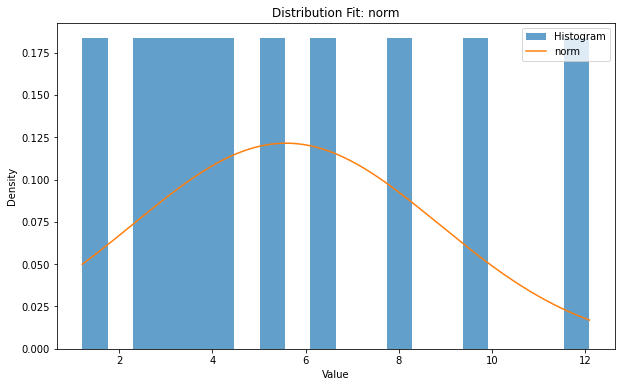

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

def plot_histogram_and_fit(column, distribution_name):
    plt.figure(figsize=(10, 6))

    plt.hist(column, bins=20, density=True, alpha=0.7, label='Histogram')

    if distribution_name == 'gaussian_kde':
        kde = KernelDensity(bandwidth=0.2).fit(column.values.reshape(-1, 1))
        x_range = np.linspace(min(column), max(column), 1000)
        log_density = kde.score_samples(x_range.reshape(-1, 1))
        plt.plot(x_range, np.exp(log_density), label='Gaussian KDE')

    else:
        params = getattr(stats, distribution_name).fit(column)
        x_range = np.linspace(min(column), max(column), 1000)
        fitted_distribution = getattr(stats, distribution_name)(*params)
        plt.plot(x_range, fitted_distribution.pdf(x_range), label=distribution_name)

    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(f'Distribution Fit: {distribution_name}')
    plt.legend()
    plt.show()

def detect_and_plot_distribution(column):
    detected_distribution = detect_distribution(column)
    print(f"The detected distribution is: {detected_distribution}")
    plot_histogram_and_fit(column, detected_distribution)

# Example usage
data = pd.Series([1.2, 2.5, 3.7, 5.1, 7.9, 6.4, 9.8, 4.2, 2.9, 12.1])
detect_and_plot_distribution(data)


In [4]:
from ydata_profiling import ProfileReport

/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [5]:
import json
import pandas as pd

In [6]:
train_df = pd.read_csv("../data/tabular/census.csv")
train_report = ProfileReport(train_df, title="Real", minimal=False)

In [18]:
sdv_datasets = ["adult", "credit", "census", "child", "covtype", "insurance", "intrusion"]
other_datasets = ["health_insurance", "accidential_drug_deaths", "loan"] # "kddcup"]

all_datasets = sdv_datasets + other_datasets

In [19]:
all_datasets

['adult',
 'credit',
 'census',
 'child',
 'covtype',
 'insurance',
 'intrusion',
 'health_insurance',
 'accidential_drug_deaths',
 'loan']

In [22]:
ML_CLASSIFICATION_TASK_DATASETS = [
    "adult", "census", "credit", "covtype", "loan", "intrusion"]
ML_REGRESSION_TASK_DATASETS = ["health_insurance"]
# drugs, child, car insurance
ML_TASKS_TARGET_CLASS = {
    "adult": "label",
    "census": "label",
    "credit": "label",
    "covtype": "label",
    "loan": "Personal Loan",
    "intrusion": "label",
    "health_insurance": "charges",
}

In [23]:
cmp_datasets = {
    "name": [],
    "memory_size": [],
    "record_size": [],
    "ml_task": [],
    # "p_duplicates": [],
    "p_cells_missing": [],
    "n_rows": [],
    "n_cols": [],
    "n_numeric": [],
    "n_categoric": [],
    "n_boolean": [], 
    "n_datetime": [], 
    "n_text": []
}

for dn in all_datasets:
    
    if dn in ML_CLASSIFICATION_TASK_DATASETS:
        cmp_datasets["ml_task"].append("Classification")
    elif dn in ML_REGRESSION_TASK_DATASETS:
        cmp_datasets["ml_task"].append("Regression")
    else:
        cmp_datasets["ml_task"].append("")
    try:
        # Load the JSON file into a dictionary
        with open(f"../dataset_profiles/tabular/{dn}/{dn}.json", "r") as json_file:
            data_dict = json.load(json_file)            
        
        tab_data = data_dict["table"]
        cmp_datasets["name"].append(dn)
        cmp_datasets["memory_size"].append(tab_data["memory_size"])
        cmp_datasets["record_size"].append(tab_data["record_size"])
        # cmp_datasets["p_duplicates"].append(tab_data["p_duplicates"])
        cmp_datasets["p_cells_missing"].append(tab_data["p_cells_missing"])
        cmp_datasets["n_rows"].append(tab_data["n"])
        cmp_datasets["n_cols"].append(tab_data["n_var"])
        cmp_datasets["n_numeric"].append(tab_data["types"]["Numeric"])
        try:
            cmp_datasets["n_categoric"].append(tab_data["types"]["Categorical"])
        except Exception as e:
            cmp_datasets["n_categoric"].append(0)
        try:
            cmp_datasets["n_boolean"].append(tab_data["types"]["Boolean"])
        except Exception as e:
            cmp_datasets["n_boolean"].append(0)
            
        try:
            cmp_datasets["n_text"].append(tab_data["types"]["Text"])
        except Exception as e:
            cmp_datasets["n_text"].append(0)
            
        try:
            cmp_datasets["n_datetime"].append(tab_data["types"]["DateTime"])
        except Exception as e:
            cmp_datasets["n_datetime"].append(0)
             
    except Exception as e: 
        print(e)

In [24]:
cmp_datasets_df = pd.DataFrame(cmp_datasets)

In [25]:
cmp_datasets_df

,name,memory_size,record_size,ml_task,p_cells_missing,n_rows,n_cols,n_numeric,n_categoric,n_boolean,n_datetime,n_text
0,adult,4167936,128.003931,Classification,0.000000,32561,16,7,9,0,0,0
1,credit,70632264,248.000449,Classification,0.000000,284807,31,30,1,0,0,0
2,census,100559888,336.000428,Classification,0.000102,299285,42,10,31,0,0,1
3,child,3360128,168.006400,,0.019826,20000,21,1,14,6,0,0
4,covtype,260293504,448.000220,Classification,0.000000,581012,56,12,44,0,0,0
5,insurance,3500128,175.006400,,0.052054,20000,28,1,20,7,0,0
6,intrusion,165991184,336.000259,Classification,0.000000,494021,42,14,27,0,0,1
7,health_insurance,75056,56.095665,Regression,0.000000,1338,7,4,2,1,0,0
8,accidential_drug_deaths,2443008,320.016767,,0.561711,7634,40,1,9,21,1,8
9,loan,560128,112.025600,Classification,0.000000,5000,14,7,7,0,0,0


In [14]:
def get_minimal_profile(variables_dict):
    profiles = {}
    profiles["table"] = variables_dict["table"]
    profiles["alerts"] = variables_dict["alerts"]
    profiles["variables"] = {}
    for k, v in variables_dict["variables"].items():
        dtype = v["type"]
        var_profile = {}
        
        # Supported Ydata types
        # - Boolean
        # - Numerical
        # - Date (and Datetime)
        # - Categorical
        # - Time-series
        # - URL
        # - Path
        # - File
        # - Image
        if dtype == "Categorical":
            var_profile = {
                "type": dtype,
                "n_distinct": v["n_distinct"],
                "n_missing": v["n_missing"],
                "freq_counts": v["word_counts"],
                "imbalance": v["imbalance"]
            }
        elif dtype == "Numeric":
            var_profile = {
                "type": dtype,
                "n_distinct": v["n_distinct"],
                "n_missing": v["n_missing"],             
                "kurtosis": v["kurtosis"],
                "skewness": v["skewness"],
                "monotonic": v["monotonic"]
            }
        elif dtype == "Boolean":
            var_profile = {
                "type": dtype,
                "n_distinct": v["n_distinct"],
                "n_missing": v["n_missing"],
                "imbalance": v["imbalance"]
            }
        else:    
            var_profile = v
            print("None a valid type : ", dtype)
        profiles["variables"][k] = var_profile
    return profiles

In [17]:
import os

In [22]:
# for dataset_name in single_table_dataset_names:
#     print("-*-"*10)
#     print(" "*4, dataset_name)
#     print("-*-"*10)
    
# dataset_name = "personal_loan"
dataset_name = "kddcup"
# dataset_name = "accidential_drug_deaths"

output_path = f"../dataset_profiles/tabular/{dataset_name}"
if not os.path.exists(output_path):
    os.makedirs(output_path)

# df = pd.read_csv(f"data/tabular/{dataset_name}.csv")


# df = pd.read_csv(f"../sample_datasets/{dataset_name}.csv")
df = pd.read_csv(f"../kddcup.csv")

profile = ProfileReport(df, minimal=False)

# As a JSON string
json_data = profile.to_json()

json_dict = json.loads(json_data)
var_profiles = get_minimal_profile(json_dict)

# Save the dictionary as a JSON file
with open(f"{output_path}/{dataset_name}.json", "w") as json_file:
    json.dump(var_profiles, json_file)

# As a file
profile.to_file(f"{output_path}/{dataset_name}_detailed.json")
profile.to_file(f"{output_path}/{dataset_name}.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'cannot handle a non-unique multi-index!')
  warnings.warn(


Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

None a valid type :  Text


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
kdd_col = list(df.columns)

In [34]:
df2 = pd.read_csv(f"../data/tabular/intrusion.csv")

In [38]:
intrusion_col = list(df2.columns)

In [41]:
len(kdd_col), len(intrusion_col)

(40, 42)

In [39]:
common_elements = list(set(kdd_col).intersection(intrusion_col))


In [42]:
len(common_elements)

39

In [43]:
elements_only_in_kdd_col = list(set(kdd_col) - set(intrusion_col))

In [44]:
elements_only_in_kdd_col

['num_outbound_cmds']

In [45]:
elements_only_in_intrusion_col = list(set(intrusion_col) - set(kdd_col))
elements_only_in_intrusion_col

['dst_host_srv_rerror_rate', 'label', 'Unnamed: 0']

In [118]:
a_df = pd.read_csv("../data/tabular/adult.csv")
c_df = pd.read_csv("../data/tabular/census.csv")

In [120]:
a_col = list(a_df.columns)
c_col = list(c_df.columns)

In [121]:
common_elements = list(set(a_col).intersection(c_col))

In [123]:
common_elements

['label', 'sex', 'education', 'Unnamed: 0', 'age', 'race']

In [124]:
elements_only_in_a_col = list(set(a_col) - set(c_col))

In [125]:
elements_only_in_a_col

['occupation',
 'native-country',
 'capital-gain',
 'capital-loss',
 'fnlwgt',
 'workclass',
 'hours-per-week',
 'marital-status',
 'relationship',
 'education-num']

In [ ]:
ml_tasks = {
 'adult': 'Classification'
 'credit': 'Classification'
 'census': 'Classification'
 # 'child': 'Classification'
 'covtype': 'Classification'
 'insurance': 'Classification'
 'intrusion': 'Classification'
 'health_insurance': 'Regression'
 # 'accidential_drug_deaths': 'Classification'
 'personal_loan': 'Classification'
}

In [59]:
%matplotlib inline

In [95]:
def plot_target_distribution(df, dataset_name, col_name='label'):
    # Count the frequency of each category
    category_counts = df[col_name].value_counts()

    # Plot the frequency graph using pandas
    category_counts.plot(kind='bar')

    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.title(dataset_name)
    plt.show()

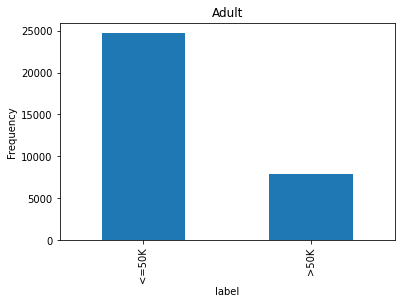

In [96]:
df = pd.read_csv("../data/tabular/Adult.csv")
plot_target_distribution(df, "Adult", "label")

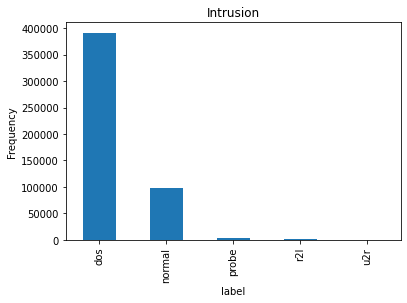

In [97]:
df = pd.read_csv("../data/tabular/Intrusion.csv")
plot_target_distribution(df, "Intrusion", "label")

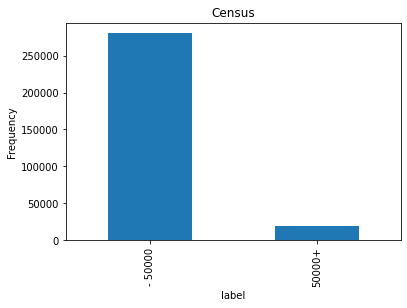

In [98]:
df = pd.read_csv("../data/tabular/Census.csv")
plot_target_distribution(df, "Census", "label")

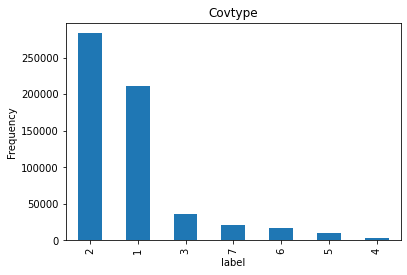

In [99]:
df = pd.read_csv("../data/tabular/Covtype.csv")
plot_target_distribution(df, "Covtype", "label")

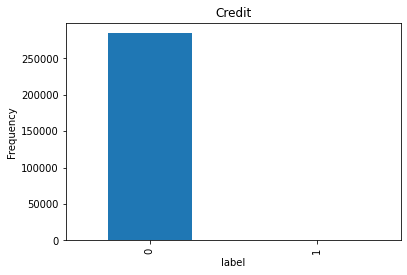

In [100]:
df = pd.read_csv("../data/tabular/Credit.csv")
plot_target_distribution(df, "Credit", "label")

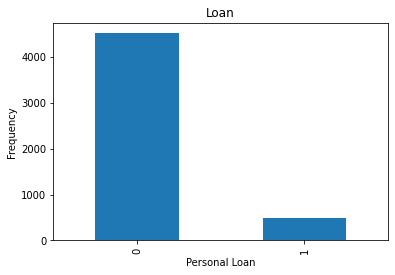

In [101]:
df = pd.read_csv("../sample_datasets/personal_loan.csv")
plot_target_distribution(df, "Loan", "Personal Loan")

<AxesSubplot:ylabel='Frequency'>

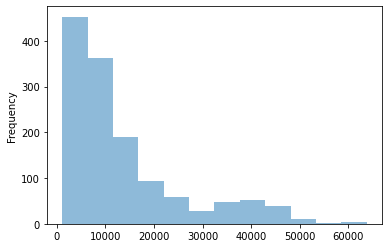

In [81]:
df_health = pd.read_csv("../sample_datasets/health_insurance.csv")
df_health["charges"].plot.hist(bins=12, alpha=0.5)

In [113]:
df = pd.read_csv("../sample_datasets/personal_loan.csv")

df_copy = df.copy()

X_train, X_test, y_train, y_test = stratified_split_dataframe(df_copy, target_column='Personal Loan', test_size=0.2, random_state=42)


In [117]:
y_test

2388    0
2373    1
4347    0
665     0
4182    0
       ..
1590    0
4986    0
433     0
1821    0
686     0
Name: Personal Loan, Length: 1000, dtype: int64

In [107]:
y_train

408     0
3737    0
3889    0
568     0
1041    0
       ..
4587    0
2341    0
1585    0
3152    0
4785    0
Name: Personal Loan, Length: 4000, dtype: int64

In [104]:
print("X_train:\n", df.shape)
print("X_train:\n", X_train.shape)
print("X_test:\n", X_test.shape)
print("y_train:\n", y_train.shape)
print("y_test:\n", y_test.shape)

X_train:
 (5000, 14)
X_train:
 (4000, 13)
X_test:
 (1000, 13)
y_train:
 (4000,)
y_test:
 (1000,)


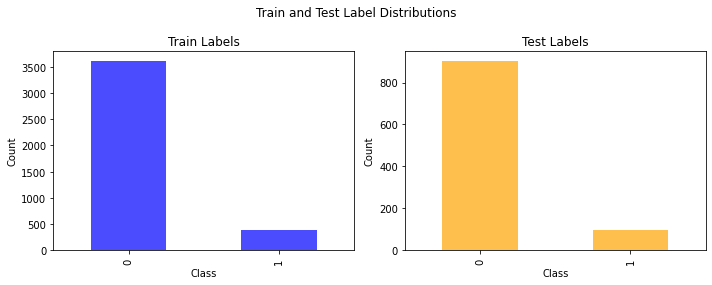

In [108]:
# Plot label distributions
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Train and Test Label Distributions')

y_train.value_counts().plot(kind='bar', ax=axes[0], color='blue', alpha=0.7)
axes[0].set_title('Train Labels')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

y_test.value_counts().plot(kind='bar', ax=axes[1], color='orange', alpha=0.7)
axes[1].set_title('Test Labels')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def shuffle_and_split_dataframe(df, test_size=0.2, random_state=None):
    """
    Shuffle and split a pandas DataFrame into training and testing subsets.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.
    - test_size (float): The proportion of the dataset to include in the test split.
    - random_state (int or None): Seed for the random number generator.

    Returns:
    - X_train (pandas.DataFrame): Training features.
    - X_test (pandas.DataFrame): Test features.
    """
    # Shuffle the DataFrame
    shuffled_df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    X = shuffled_df

    X_train, X_test = train_test_split(
        X, test_size=test_size, random_state=random_state
    )

    return X_train, X_test

# Example usage
data = {
    'feature1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'feature2': [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
}

df = pd.DataFrame(data)

X_train, X_test = shuffle_and_split_dataframe(df, test_size=0.2, random_state=42)

print("X_train:\n", X_train)
print("X_test:\n", X_test)


X_train:
    feature1  feature2
5         3        13
0         9        19
7         5        15
2         6        16
9         7        17
4         8        18
3         1        11
6        10        20
X_test:
    feature1  feature2
8         4        14
1         2        12
